<a href="https://colab.research.google.com/github/y-lims/DADS7202_Potato/blob/main/Potato_cls_vgg16_v1_seed1_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [52]:
!ls -l /root/.keras/


total 8
-rw-r--r-- 1 root root  120 Aug  1 13:40 keras.json
drwxr-xr-x 2 root root 4096 Aug  1 13:43 models


In [53]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [54]:
# List all NVIDIA GPUs as available in this computer (or Colab's session)
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


# 1. Prepare the environment

## Import Lib

In [55]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

from google.colab import drive
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

import os
import sys
import numpy as np
import pandas as pd
import random as rn
import sklearn
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow import keras
# from keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image, display
import matplotlib.cm as cmp
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split

import os
import numpy as np
import tensorflow as tf

import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt



Python 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]

NumPy 1.26.4

Matplotlib 3.7.1

TensorFlow 2.17.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 0 GPU(s):


## Set seed 🚧🚧🚧🚧🚧🚧🚧

In [56]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np_random_seed = 2
tf_random_seed = 2
model_name = 'vgg16'
version = 'v1'
seedno = 2


np.random.seed(np_random_seed)
tf.random.set_seed(tf_random_seed)

# 2. Load the pretrained model (only the feature extractor) 🚧🚧🚧🚧🚧🚧

In [57]:
# Load the ImageNet VGG-16 model, ***excluding*** the classifier
# For VGG-16, the default input_shape is 224x224x3
img_w,img_h = 224,224
vgg_extractor = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3))

vgg_extractor.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

# 3. Prepare our dataset

Mount Drive

In [58]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define Class mapping

In [59]:
folder_path = '/content/drive/My Drive/Final_Potato/train_data/archive/'

d = {}
for filename in os.listdir(folder_path):
  # print(filename)
  if filename != 'Healthy':
    d[filename] = 1
  else:
    d[filename] = 0

print(d)

# class_mapping = d
class_mapping = {'Healthy': 0, 'Blackleg': 1, 'Black Scurf': 1, 'Pink Rot': 1, 'Common Scab': 1, 'Dry Rot': 1}

# class_mapping = {'Healthy': 0, 'Blackleg': 1, 'Black Scurf': 2, 'Pink Rot': 3, 'Common Scab': 4, 'Dry Rot': 5}

{'Blackleg': 1, 'Black Scurf': 1, 'Pink Rot': 1, 'Common Scab': 1, 'Dry Rot': 1, 'Healthy': 0}


## Load Train set

==== Healthy ====
Shape of x (Healthy): (305, 224, 224, 3)
Shape of y (Healthy): (305,)
latest index :  304


array([[[ 62,  56,  32],
        [ 63,  57,  33],
        [ 66,  60,  36],
        ...,
        [ 88,  70,  48],
        [ 86,  68,  46],
        [ 85,  67,  45]],

       [[ 66,  60,  36],
        [ 67,  61,  37],
        [ 69,  63,  39],
        ...,
        [ 88,  70,  48],
        [ 87,  69,  47],
        [ 86,  68,  46]],

       [[ 70,  64,  40],
        [ 71,  65,  41],
        [ 72,  66,  42],
        ...,
        [ 89,  71,  49],
        [ 88,  70,  48],
        [ 87,  69,  47]],

       ...,

       [[ 89,  63,  46],
        [ 90,  64,  47],
        [ 92,  66,  49],
        ...,
        [127, 101,  76],
        [126, 100,  75],
        [125,  99,  74]],

       [[ 88,  62,  45],
        [ 89,  63,  46],
        [ 91,  65,  48],
        ...,
        [126, 100,  75],
        [125,  99,  74],
        [124,  98,  73]],

       [[ 88,  62,  45],
        [ 89,  63,  46],
        [ 91,  65,  48],
        ...,
        [126, 100,  75],
        [124,  98,  73],
        [124,  98,  73]]], dtype=uint8)
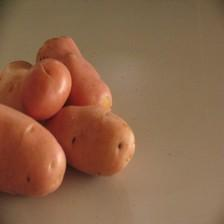

==== Blackleg ====
Shape of x (Blackleg): (60, 224, 224, 3)
Shape of y (Blackleg): (60,)
latest index :  364


array([[[230, 237, 243],
        [230, 237, 243],
        [231, 238, 244],
        ...,
        [220, 225, 231],
        [219, 224, 230],
        [219, 224, 230]],

       [[230, 237, 243],
        [230, 237, 243],
        [231, 238, 244],
        ...,
        [219, 224, 230],
        [219, 224, 230],
        [220, 225, 231]],

       [[231, 238, 244],
        [231, 238, 244],
        [232, 239, 245],
        ...,
        [218, 223, 229],
        [219, 224, 230],
        [220, 225, 231]],

       ...,

       [[235, 240, 244],
        [235, 240, 244],
        [236, 241, 245],
        ...,
        [216, 219, 226],
        [216, 219, 226],
        [216, 219, 226]],

       [[235, 240, 244],
        [235, 240, 244],
        [236, 241, 245],
        ...,
        [216, 219, 226],
        [216, 219, 226],
        [216, 219, 226]],

       [[235, 240, 244],
        [235, 240, 244],
        [236, 241, 245],
        ...,
        [215, 218, 225],
        [215, 218, 225],
        [215, 218, 225]]], dtype=uint8)
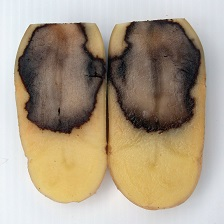


==== Black Scurf ====
Shape of x (Black Scurf): (58, 224, 224, 3)
Shape of y (Black Scurf): (58,)
latest index :  422


array([[[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       ...,

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]]], dtype=uint8)
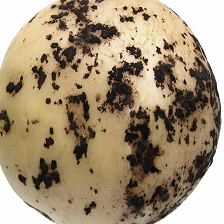


==== Pink Rot ====
Shape of x (Pink Rot): (57, 224, 224, 3)
Shape of y (Pink Rot): (57,)
latest index :  479


array([[[11, 11, 11],
        [12, 12, 12],
        [13, 13, 13],
        ...,
        [11, 11, 11],
        [13, 13, 13],
        [12, 12, 12]],

       [[11, 11, 11],
        [12, 12, 12],
        [13, 13, 13],
        ...,
        [11, 11, 11],
        [13, 13, 13],
        [12, 12, 12]],

       [[11, 11, 11],
        [12, 12, 12],
        [13, 13, 13],
        ...,
        [11, 11, 11],
        [13, 13, 13],
        [12, 12, 12]],

       ...,

       [[14, 14, 14],
        [15, 15, 15],
        [15, 15, 15],
        ...,
        [13, 13, 13],
        [12, 12, 12],
        [13, 13, 13]],

       [[15, 15, 15],
        [16, 16, 16],
        [16, 16, 16],
        ...,
        [14, 14, 14],
        [13, 13, 13],
        [16, 16, 16]],

       [[15, 15, 15],
        [16, 16, 16],
        [16, 16, 16],
        ...,
        [14, 14, 14],
        [13, 13, 13],
        [16, 16, 16]]], dtype=uint8)
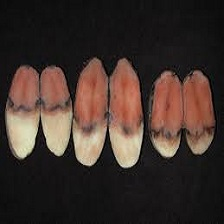


==== Common Scab ====
Shape of x (Common Scab): (62, 224, 224, 3)
Shape of y (Common Scab): (62,)
latest index :  541


array([[[ 92,  72,  47],
        [ 90,  70,  45],
        [ 89,  69,  44],
        ...,
        [136,  69,  50],
        [133,  66,  49],
        [130,  63,  46]],

       [[ 84,  64,  39],
        [ 82,  62,  37],
        [ 80,  60,  35],
        ...,
        [129,  67,  46],
        [128,  65,  47],
        [128,  65,  47]],

       [[ 81,  61,  36],
        [ 78,  58,  33],
        [ 77,  57,  33],
        ...,
        [127,  71,  48],
        [127,  70,  50],
        [129,  72,  52]],

       ...,

       [[ 46,  82, 130],
        [ 46,  84, 129],
        [ 46,  85, 128],
        ...,
        [193, 133,  63],
        [196, 136,  66],
        [203, 144,  74]],

       [[ 46,  84, 133],
        [ 44,  85, 131],
        [ 43,  84, 128],
        ...,
        [191, 130,  67],
        [186, 126,  63],
        [191, 133,  69]],

       [[ 43,  83, 134],
        [ 42,  82, 131],
        [ 41,  82, 126],
        ...,
        [191, 131,  69],
        [182, 122,  60],
        [183, 125,  62]]], dtype=uint8)
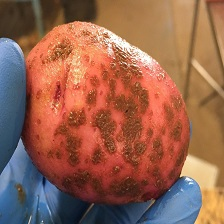


==== Dry Rot ====
Shape of x (Dry Rot): (60, 224, 224, 3)
Shape of y (Dry Rot): (60,)
latest index :  601


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [240, 249, 248],
        [240, 249, 248],
        [240, 249, 248]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [240, 249, 248],
        [240, 249, 248],
        [240, 249, 248]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [240, 249, 248],
        [240, 249, 248],
        [241, 250, 249]]], dtype=uint8)
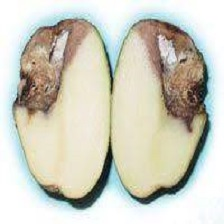

In [60]:
allowed_extensions = (".JPG", ".jpg", ".jpeg", ".JPEG", ".PNG", ".png")
# class_mapping = {'Healthy': 0, 'Blackleg': 1, 'Black Scurf': 1, 'Pink Rot': 1, 'Common Scab': 1, 'Dry Rot': 1}
class_mapping = {'Healthy': 0, 'Blackleg': 1, 'Black Scurf': 2, 'Pink Rot': 3, 'Common Scab': 4, 'Dry Rot': 5}

def process_dataset_nosplit(folder_path, class_name):

    print(f'==== {class_name} ====')
    x, y, z = [], [], []
    for filename in os.listdir(os.path.join(folder_path, class_name)):
        if filename.endswith(allowed_extensions):
            file_path = os.path.join(folder_path, class_name, filename)
            img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
            img_array = tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8)
            x.append(img_array)
            y.append(class_mapping[class_name])
            z.append([class_name, filename])


    x = np.array(x)
    y = np.array(y).reshape(-1,)
    print(f"Shape of x ({class_name}):", x.shape)
    print(f"Shape of y ({class_name}):", y.shape)
    return x, y, z

# ==========================================================================================

folder_path = '/content/drive/My Drive/Final_Potato/train_data/archive/'
x, y, z = process_dataset_nosplit(folder_path, 'Healthy')
x_combined, y_combined, z_combined = x, y, z
print('latest index : ', len(x_combined) - 1)
display(x[0])

check_ind = [len(x_combined) - 1]
check_class = ['Healthy']
for i in list(class_mapping.keys())[1:]:
    x, y, z = process_dataset_nosplit(folder_path, i)
    x_combined = np.concatenate((x_combined, x), axis=0)
    y_combined = np.concatenate((y_combined, y), axis=0)
    z_combined = np.concatenate((z_combined, z), axis=0)
    print('latest index : ', len(x_combined) - 1)
    display(x[0])
    print()
    check_ind.append(len(x_combined) - 1)
    check_class.append(i)

x_train, y_train = x_combined, y_combined


In [61]:
train_information_df = pd.DataFrame(z_combined, columns=['class', 'filename']).reset_index(drop=0)
display(train_information_df)

,index,class,filename
0,0,Healthy,freshPotato (503).jpg
1,1,Healthy,freshPotato (410).jpg
2,2,Healthy,freshPotato (17).jpg
3,3,Healthy,freshPotato (273).jpg
4,4,Healthy,freshPotato (316).jpg
...,...,...,...
597,597,Dry Rot,36.jpg
598,598,Dry Rot,7.jpg
599,599,Dry Rot,60.jpg
600,600,Dry Rot,9.jpg


Vlaidate image in train set

Healthy


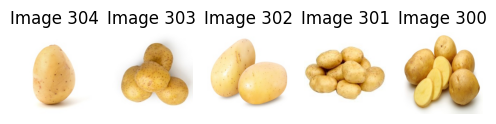

Blackleg


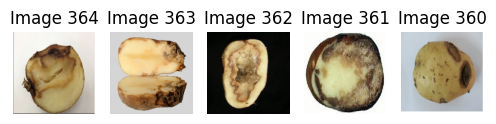

Black Scurf


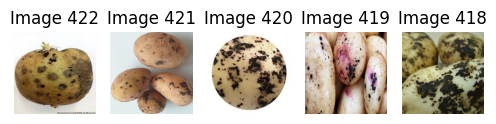

Pink Rot


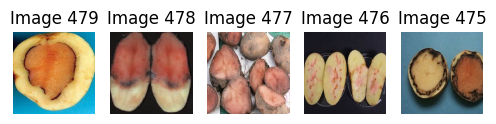

Common Scab


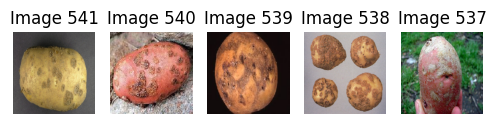

Dry Rot


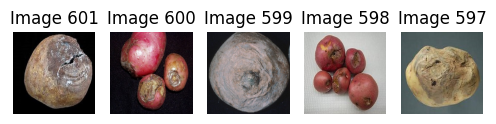

In [62]:
import matplotlib.pyplot as plt


for k,i in enumerate(check_ind):
    print(check_class[k])
    display_ind = list(range(i, i-5, -1))

    # Set up the subplots
    fig, axes = plt.subplots(1, 5, figsize=(5, 5))  # Adjust figsize for better display

    for j in range(5):
        # Display each image in the subplot
        axes[j].imshow(x_combined[display_ind[j]])
        axes[j].set_title(f"Image {display_ind[j]}")
        axes[j].axis('off')  # Hide the axes

    # Adjust layout
    plt.tight_layout()
    plt.show()


## Load Test set

==== Healthy ====
Shape of x (Healthy): (56, 224, 224, 3)
Shape of y (Healthy): (56,)
latest index :  55


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
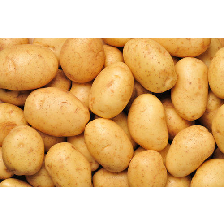

==== Blackleg ====
Shape of x (Blackleg): (22, 224, 224, 3)
Shape of y (Blackleg): (22,)
latest index :  77


array([[[ 46,  94, 117],
        [ 62,  91, 121],
        [ 60,  95, 117],
        ...,
        [ 50,  91, 109],
        [ 47,  87, 122],
        [ 49,  90,  94]],

       [[ 61,  97, 111],
        [ 60,  94, 122],
        [ 56,  90, 117],
        ...,
        [ 52,  88, 120],
        [ 51,  92, 112],
        [ 43,  80, 106]],

       [[ 62,  91, 123],
        [ 61,  96, 118],
        [ 59,  91, 116],
        ...,
        [ 50,  88, 111],
        [ 51,  88, 115],
        [ 45,  82, 109]],

       ...,

       [[ 49,  91, 115],
        [ 53,  95, 117],
        [ 49,  96, 126],
        ...,
        [ 45,  92, 118],
        [ 48,  92, 131],
        [ 46,  93, 109]],

       [[ 51,  93, 117],
        [ 51,  94, 113],
        [ 52,  96, 123],
        ...,
        [ 44,  92, 115],
        [ 48,  92, 117],
        [ 45,  92, 112]],

       [[ 55,  94, 123],
        [ 57, 101, 128],
        [ 52,  95, 130],
        ...,
        [ 46,  94, 106],
        [ 47,  93, 117],
        [ 46,  90, 117]]], dtype=uint8)
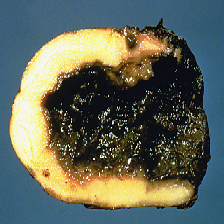


==== Black Scurf ====
Shape of x (Black Scurf): (66, 224, 224, 3)
Shape of y (Black Scurf): (66,)
latest index :  143


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
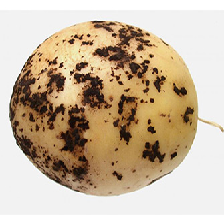


==== Pink Rot ====
Shape of x (Pink Rot): (49, 224, 224, 3)
Shape of y (Pink Rot): (49,)
latest index :  192


array([[[ 8,  8,  8],
        [ 6,  6,  6],
        [14, 14, 14],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[ 9,  9,  9],
        [ 8,  8,  8],
        [ 8,  8,  8],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[ 5,  5,  5],
        [ 6,  6,  6],
        [ 4,  4,  4],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       ...,

       [[ 3,  3,  3],
        [ 4,  4,  4],
        [ 4,  4,  4],
        ...,
        [ 5,  5,  5],
        [ 5,  5,  5],
        [ 5,  5,  5]],

       [[ 8,  8,  8],
        [ 7,  7,  7],
        [ 8,  8,  8],
        ...,
        [ 2,  2,  2],
        [ 2,  2,  2],
        [ 2,  2,  2]],

       [[66, 66, 66],
        [65, 65, 65],
        [66, 66, 66],
        ...,
        [65, 65, 65],
        [65, 65, 65],
        [65, 65, 65]]], dtype=uint8)
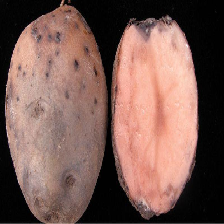


==== Common Scab ====
Shape of x (Common Scab): (60, 224, 224, 3)
Shape of y (Common Scab): (60,)
latest index :  252


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
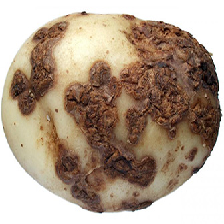


==== Dry Rot ====
Shape of x (Dry Rot): (51, 224, 224, 3)
Shape of y (Dry Rot): (51,)
latest index :  303


array([[[234, 236, 235],
        [234, 236, 235],
        [234, 236, 235],
        ...,
        [242, 244, 243],
        [242, 244, 243],
        [242, 244, 243]],

       [[234, 236, 235],
        [234, 236, 235],
        [234, 236, 235],
        ...,
        [242, 244, 243],
        [242, 244, 243],
        [242, 244, 243]],

       [[234, 236, 235],
        [234, 236, 235],
        [234, 236, 235],
        ...,
        [242, 244, 243],
        [242, 244, 243],
        [242, 244, 243]],

       ...,

       [[228, 230, 229],
        [228, 230, 229],
        [228, 230, 229],
        ...,
        [240, 242, 241],
        [240, 242, 241],
        [240, 242, 241]],

       [[228, 230, 229],
        [228, 230, 229],
        [228, 230, 229],
        ...,
        [240, 242, 241],
        [240, 242, 241],
        [240, 242, 241]],

       [[228, 230, 229],
        [228, 230, 229],
        [228, 230, 229],
        ...,
        [240, 242, 241],
        [240, 242, 241],
        [240, 242, 241]]], dtype=uint8)
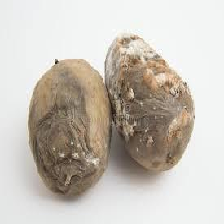

In [63]:
# ==========================================================================================

folder_path = '/content/drive/My Drive/Final_Potato/test_data/'
x, y, z = process_dataset_nosplit(folder_path, 'Healthy')
x_combined, y_combined, z_combined = x, y, z
print('latest index : ', len(x_combined) - 1)
display(x[0])

check_ind = [len(x_combined) - 1]
check_class = ['Healthy']
for i in list(class_mapping.keys())[1:]:
    x, y, z = process_dataset_nosplit(folder_path, i)
    x_combined = np.concatenate((x_combined, x), axis=0)
    y_combined = np.concatenate((y_combined, y), axis=0)
    z_combined = np.concatenate((z_combined, z), axis=0)
    print('latest index : ', len(x_combined) - 1)
    display(x[0])
    print()
    check_ind.append(len(x_combined) - 1)
    check_class.append(i)

x_test, y_test = x_combined, y_combined


In [64]:
test_information_df = pd.DataFrame(z_combined, columns=['class', 'filename']).reset_index(drop=0)
display(test_information_df)

,index,class,filename
0,0,Healthy,11.jpg
1,1,Healthy,4.jpg
2,2,Healthy,6.jpg
3,3,Healthy,3.jpg
4,4,Healthy,8.jpg
...,...,...,...
299,299,Dry Rot,DR45.jpg
300,300,Dry Rot,DR46.jpg
301,301,Dry Rot,DR47.jpg
302,302,Dry Rot,DR48.jpg


Train and test dataset

In [65]:
from sklearn.model_selection import train_test_split


# # Set a random seed for reproducibility
# split_random_seed = 42

# # Perform train-test split with stratification and random seed
# x_train, x_test, y_train, y_test = train_test_split(x_combined, y_combined, test_size=0.2, stratify=y_combined, random_state=split_random_seed)

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')


Shape of x_train: (602, 224, 224, 3)
Shape of y_train: (602,)
Shape of x_test: (304, 224, 224, 3)
Shape of y_test: (304,)


Merge all dataset together

In [66]:
print('==== Full train set ====')
print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print()


print('==== Full test set ====')
print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

print()
print('==== Total ====')
print("Total images : ",x_train.shape[0] + x_test.shape[0])

==== Full train set ====
Shape of x_train: (602, 224, 224, 3)
Shape of y_train: (602,)

==== Full test set ====
Shape of x_test: (304, 224, 224, 3)
Shape of y_test: (304,)

==== Total ====
Total images :  906


In [67]:
# (x_train , y_train), (x_test , y_test) = tf.keras.datasets.cifar10.load_data()

# Inspect the dataset
print( f"x_train: type={type(x_train)} , dtype={x_train.dtype} , shape={x_train.shape} , min={x_train.min(axis=None)} , max={x_train.max(axis=None)}" )
print( f"y_train: type={type(y_train)} , dtype={y_train.dtype} , shape={y_train.shape} , min={min(y_train)} , max={max(y_train)}" )
print( f"x_test: type={type(x_test)} , dtype={x_test.dtype} , shape={x_test.shape} , min={x_test.min(axis=None)} , max={x_test.max(axis=None)}"  )
print( f"y_test: type={type(y_test)} , dtype={y_test.dtype} , shape={y_test.shape} , min={min(y_test)} , max={max(y_test)}" )

x_train: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(602, 224, 224, 3) , min=0 , max=255
y_train: type=<class 'numpy.ndarray'> , dtype=int64 , shape=(602,) , min=0 , max=5
x_test: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(304, 224, 224, 3) , min=0 , max=255
y_test: type=<class 'numpy.ndarray'> , dtype=int64 , shape=(304,) , min=0 , max=5


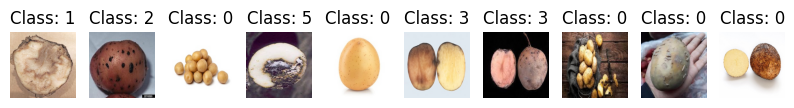

In [68]:
import random
import matplotlib.pyplot as plt

# Set the number of images to display
num_images = 10

# Randomly select indices
random_indices = random.sample(range(len(x_train)), num_images)

# Visualize the randomly selected images
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(x_train[idx].astype('uint8'))
    plt.title(f"Class: {y_train[idx]}")
    plt.axis("off")
plt.show()


# Data Prep for specific model 🚧🚧🚧🚧🚧🚧🚧🚧

In [69]:
# Preprocess arttoy dataset to match VGG-16's requirements
x_train_vgg = tf.keras.applications.vgg16.preprocess_input(x_train)
x_test_vgg = tf.keras.applications.vgg16.preprocess_input(x_test)

print( x_train_vgg.dtype, x_train_vgg.shape, np.min(x_train_vgg), np.max(x_train_vgg) )
print( x_test_vgg.dtype, x_test_vgg.shape, np.min(x_test_vgg), np.max(x_test_vgg) )

float32 (602, 224, 224, 3) -123.68 151.061
float32 (304, 224, 224, 3) -123.68 151.061


# Data Augmentation Layer

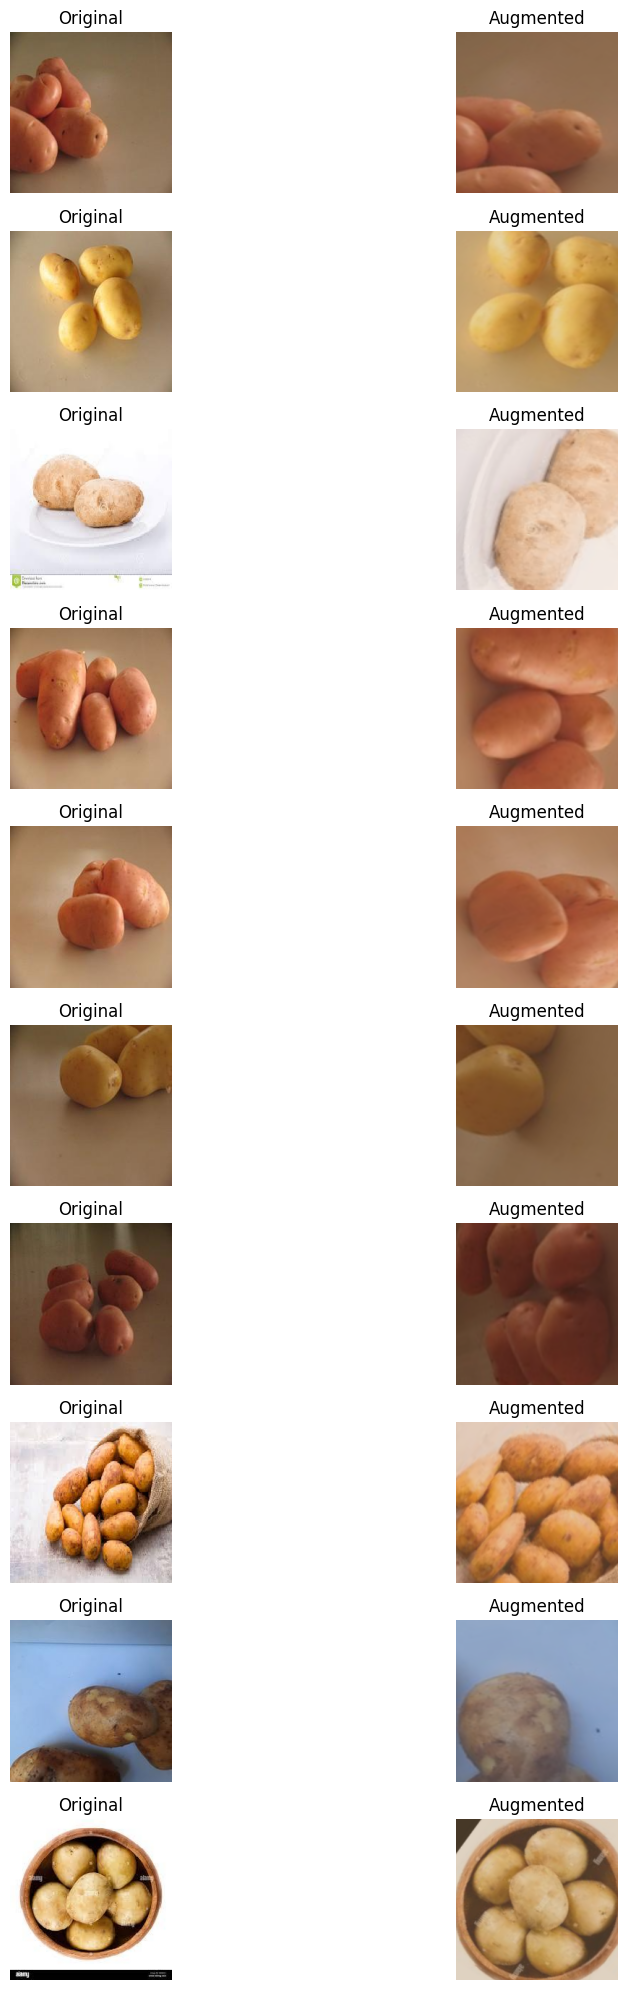

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Create data augmentation pipeline with additional transformations
data_augmentation = tf.keras.Sequential([
    # layers.Rescaling(1./255),
    # layers.RandomFlip("horizontal"),
    # layers.RandomFlip("vertical"),  # Additional flip for vertical flipping
    layers.RandomRotation(0.4),
    layers.RandomZoom(height_factor=(-0.2, -0.5), width_factor=(-0.2, -0.5)),  # Zoom in only
    layers.RandomContrast(0.9),  # Adjust contrast randomly
    # layers.RandomCrop(height=180, width=180),  # Randomly crop to 180x180 from original size
    # layers.CenterCrop(height=150, width=150),  # Center crop to 150x150
])

# ===========================================

# Assume you have image data in x_train
# We will select some images from x_train to show examples
num_examples = 10 # Number of images to display
sample_images = x_train[:num_examples]

# Apply data augmentation to sample images
augmented_images = data_augmentation(sample_images)

# Display original and augmented images in pairs
plt.figure(figsize=(12, 2 * num_examples))
for i in range(num_examples):
    # Original image
    plt.subplot(num_examples, 2, 2 * i + 1)
    plt.imshow(sample_images[i].astype("uint8"))
    plt.axis("off")
    plt.title("Original")

    # Augmented image
    plt.subplot(num_examples, 2, 2 * i + 2)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title("Augmented")

plt.tight_layout()
plt.show()


# 4. Prepare for transfer learning and finetuning

1. Add the new classification head
2. Decide whether to freeze or unfreeze any pretrained layers

## 4.1 Access and freeze layer(s) in Keras's model

In [ ]:
vgg_extractor.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### Freeze Layer

In [ ]:
# All Layer

vgg_extractor.trainable = False
# Use 'enumerate' to iterate over layers
for i, layer in enumerate(vgg_extractor.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_layer , trainable = False
Layer 1: name = block1_conv1 , trainable = False
Layer 2: name = block1_conv2 , trainable = False
Layer 3: name = block1_pool , trainable = False
Layer 4: name = block2_conv1 , trainable = False
Layer 5: name = block2_conv2 , trainable = False
Layer 6: name = block2_pool , trainable = False
Layer 7: name = block3_conv1 , trainable = False
Layer 8: name = block3_conv2 , trainable = False
Layer 9: name = block3_conv3 , trainable = False
Layer 10: name = block3_pool , trainable = False
Layer 11: name = block4_conv1 , trainable = False
Layer 12: name = block4_conv2 , trainable = False
Layer 13: name = block4_conv3 , trainable = False
Layer 14: name = block4_pool , trainable = False
Layer 15: name = block5_conv1 , trainable = False
Layer 16: name = block5_conv2 , trainable = False
Layer 17: name = block5_conv3 , trainable = False
Layer 18: name = block5_pool , trainable = False


In [ ]:
# Selective Freeze
# Access a layer by its 0-based index
a = vgg_extractor.layers[3]
print( f"Layer {a}: name = {a.name} , trainable = {a.trainable}" )

# Access a layer by its name
b = vgg_extractor.get_layer('block5_conv1')
b.trainable = True       # freeze this layer
print( f"Layer {b}: name = {b.name} , trainable = {b.trainable}" )

b = vgg_extractor.get_layer('block5_conv2')
b.trainable = True       # freeze this layer
print( f"Layer {b}: name = {b.name} , trainable = {b.trainable}" )

b = vgg_extractor.get_layer('block5_conv3')
b.trainable = True       # freeze this layer
print( f"Layer {b}: name = {b.name} , trainable = {b.trainable}" )


Layer <MaxPooling2D name=block1_pool, built=True>: name = block1_pool , trainable = False
Layer <Conv2D name=block5_conv1, built=True>: name = block5_conv1 , trainable = True
Layer <Conv2D name=block5_conv2, built=True>: name = block5_conv2 , trainable = True
Layer <Conv2D name=block5_conv3, built=True>: name = block5_conv3 , trainable = True


In [ ]:
# Iterate over all layers in the model
for i,layer in enumerate(vgg_extractor.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_layer , trainable = False
Layer 1: name = block1_conv1 , trainable = False
Layer 2: name = block1_conv2 , trainable = False
Layer 3: name = block1_pool , trainable = False
Layer 4: name = block2_conv1 , trainable = False
Layer 5: name = block2_conv2 , trainable = False
Layer 6: name = block2_pool , trainable = False
Layer 7: name = block3_conv1 , trainable = False
Layer 8: name = block3_conv2 , trainable = False
Layer 9: name = block3_conv3 , trainable = False
Layer 10: name = block3_pool , trainable = False
Layer 11: name = block4_conv1 , trainable = False
Layer 12: name = block4_conv2 , trainable = False
Layer 13: name = block4_conv3 , trainable = False
Layer 14: name = block4_pool , trainable = False
Layer 15: name = block5_conv1 , trainable = True
Layer 16: name = block5_conv2 , trainable = True
Layer 17: name = block5_conv3 , trainable = True
Layer 18: name = block5_pool , trainable = False


In [ ]:
# Create the main model
inputs = tf.keras.Input(shape=(img_w, img_h, 3))
x = data_augmentation(inputs)
x = vgg_extractor(x, training=False)  # Use the extractor with the augmented data


# FC layer
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(2, activation="softmax")(x)  # output layer for 3 classes

model = tf.keras.models.Model(inputs=inputs, outputs=new_outputs)

# Print the model summary
# model.summary()
model.summary(expand_nested=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation                 │ (10, 224, 224, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom (RandomZoom)        │ (10, 224, 224, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_contrast                 │ (10, 224, 224, 3)           │               0 │
│ (RandomContrast)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,561,282 (105.14 MB)

 Trainable params: 19,926,018 (76.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

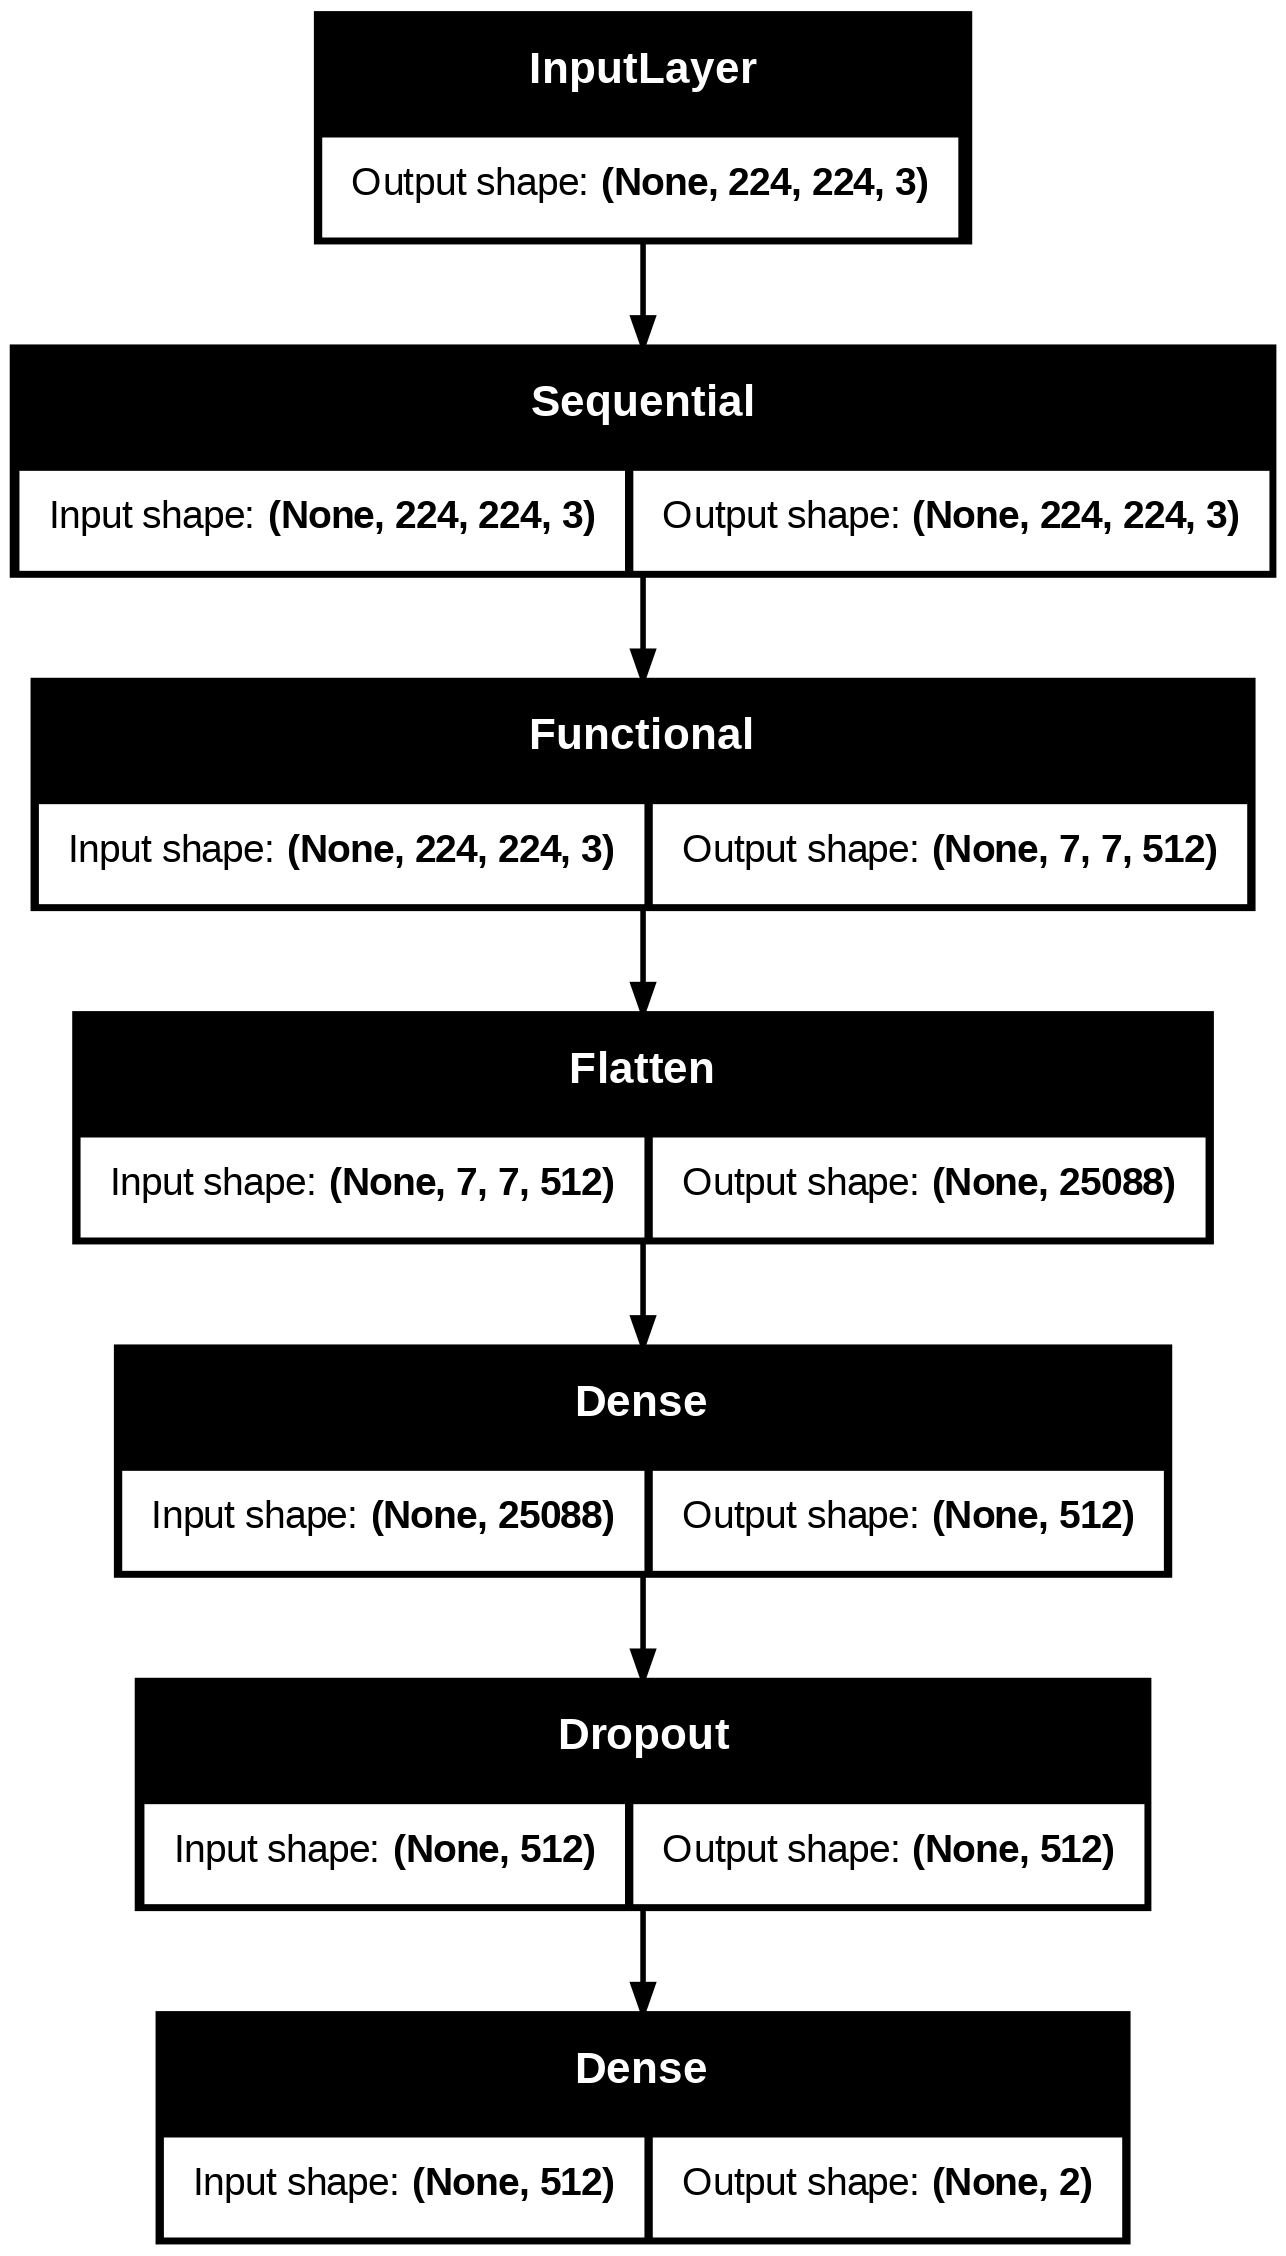

In [ ]:
keras.utils.plot_model(model, show_shapes=True)


## 4.2 Add a new classification head

In [ ]:
# x = vgg_extractor.output

# # Add our custom layer(s) to the end of the existing model
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(512, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# new_outputs = tf.keras.layers.Dense(3, activation="softmax")(x) # output layer 10 class

# # Construct the main model
# model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)
# model.summary()

## XX 4.3 Data Augmentation XX

In [ ]:
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#         #rescale=1. / 255,
#         #featurewise_center=True,
#         #featurewise_std_normalization=True,
#         #zca_whitening=False,
#         samplewise_center=True,
#         samplewise_std_normalization=True,
#         rotation_range=0,
#         width_shift_range=5.0,
#         height_shift_range=5.0,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         # vertical_flip=True,
#         validation_split=0.3)
# train_datagen.fit(x_train_vgg)


In [ ]:
# test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#         # rescale=1. / 255,
#         # featurewise_center=True,
#         # featurewise_std_normalization=True,
#         samplewise_center=True,
#         samplewise_std_normalization=True
#         )
# test_datagen.fit(x_test_vgg)

# 5. Train the model with transfer learning

No finetuning is done in this example as all pretrained layers are freezed and only newly added layers are trained.

In [ ]:
model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) ,
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                       metrics=['acc']
                     )

history = model.fit(x_train_vgg, y_train,
                    epochs=30,
                    batch_size=64,
                    verbose=2,
                    validation_split=0.2)


Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-34-97eeea6b2e8a>", line 6, in <cell line: 6>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 54, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/trainer.py", line 357, in _compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/trainer.py", line 325, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/compile_utils.py", line 609, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/compile_utils.py", line 645, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/loss.py", line 43, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py", line 27, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py", line 1853, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py", line 1567, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 645, in sparse_categorical_crossentropy

Received a label value of 3 which is outside the valid range of [0, 2).  Label values: 0 0 1 2 3 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 2 0 3 1 0 0 2 0 0 2 3 0 3 3 0 0 0 0 1 0 1 0 0 0 3 0 0 0 0 0 0 0 1 3 0 0 0 0 0 2 0 0 0 0
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_3487]

## Save model

In [ ]:
model.save(f'/content/drive/My Drive/Final_Potato/l_model/{model_name}_{version}_{seedno}_{np_random_seed}_{tf_random_seed}.h5')


Load model

In [ ]:
from tensorflow.keras.models import load_model

drive.mount('/content/drive')
model_path = f'/content/drive/My Drive/Final_Potato/l_model/{model_name}_{version}_{seedno}_{np_random_seed}_{tf_random_seed}.h5'
model = load_model(model_path)
model.summary(expand_nested=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Save History

In [ ]:

import pickle
history_path = f'/content/drive/My Drive/Final_Potato/l_model/{model_name}_{version}_{seedno}_{np_random_seed}_{tf_random_seed}_history.pkl'

# บันทึกข้อมูลประวัติการฝึกอบรมลงในไฟล์
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

# สำหรับการโหลดข้อมูลประวัติการฝึกอบรมกลับมาใช้งาน
with open(history_path, 'rb') as f:
    loaded_history = pickle.load(f)

# ทดสอบการแสดงข้อมูล
print(loaded_history)

In [ ]:
# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Evaluation 🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧

## Evaluate on Train set

In [ ]:
# Assuming class_mapping is defined somewhere above
# label = [k for k, v in class_mapping.items()]
label = ['Healthy', 'Unhealthy']
y_pred = []
for i in range(len(x_train_vgg)):
    x_input = x_train_vgg[i][np.newaxis, ...]
    y_pred.append(np.argmax(model.predict(x_input)))

cm = confusion_matrix(y_train, y_pred)

# Plotting the confusion matrix
ax = sns.heatmap(cm, annot=True, xticklabels=label, yticklabels=label, linewidths=.5)
ax.set(xlabel='Predict', ylabel='Actual')
plt.show()

# Calculating and printing accuracy, recall, precision, and f1-score
accuracy = accuracy_score(y_train, y_pred)
recall = recall_score(y_train, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed
precision = precision_score(y_train, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed
f1 = f1_score(y_train, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')

# Extracting indices of wrong predictions
train_incorrect_indices = [i for i, (pred, actual) in enumerate(zip(y_pred, y_train)) if pred != actual]
print("Indices of incorrect predictions:", train_incorrect_indices)




In [35]:
train_information_df_write = train_information_df[train_information_df['index'].isin(train_incorrect_indices)]
train_information_df_write.to_csv(f'/content/drive/My Drive/Final_Potato/l_model/{model_name}_{version}_{seedno}_{np_random_seed}_{tf_random_seed}_train_incorrect.csv', index=False)

NameError: name 'train_incorrect_indices' is not defined

In [ ]:
# Evaluate the trained model on the test set
results = model.evaluate(x_train_vgg, y_train, batch_size=128)
print( f"{model.metrics_names}: {results}" )

## Evaluate on Test set

In [ ]:
# Assuming class_mapping is defined somewhere above
# label = [k for k, v in class_mapping.items()]
# label = ['Healthy', 'Unhealthy']
y_pred = []
for i in range(len(x_test_vgg)):
    x_input = x_test_vgg[i][np.newaxis, ...]
    y_pred.append(np.argmax(model.predict(x_input)))

cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
ax = sns.heatmap(cm, annot=True, xticklabels=label, yticklabels=label, linewidths=.5)
ax.set(xlabel='Predict', ylabel='Actual')
plt.show()

# Calculating and printing accuracy, recall, precision, and f1-score
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed
precision = precision_score(y_test, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed
f1 = f1_score(y_test, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')

# Extracting indices of wrong predictions
test_incorrect_indices = [i for i, (pred, actual) in enumerate(zip(y_pred, y_test)) if pred != actual]
print("Indices of incorrect predictions:", test_incorrect_indices)


In [ ]:
# Evaluate the trained model on the test set
results = model.evaluate(x_test_vgg, y_test, batch_size=128)
print( f"{model.metrics_names}: {results}" )

# 7. Inference

In [ ]:
# (Optional) Codes for coloring frames of the predicted images
plt.rcParams["axes.linewidth"] = 5

def color_frame( ax, y_true, y_pred ):
  # Green frame means correct prediction. Red frame means incorrect prediction.
  color = 'blue' if (y_true == y_pred) else 'red'
  ax.spines['bottom'].set_color(color)
  ax.spines['top'].set_color(color)
  ax.spines['right'].set_color(color)
  ax.spines['left'].set_color(color)

In [ ]:
# Test using the model on many images

# Get a batch of samples
n = 20
samples = x_test_vgg[:n]
print(f'{samples.shape=}')

# Predict a batch of samples
y_pred = model.predict(samples)

# Interpret the results
for i in range(n):
  plt.figure(figsize=(3,3), dpi=90)
  ax = plt.gca()
  plt.imshow( x_test[i] )
  # plt.title( f"x_test[{i}]: true={y_test[i][0]}({cifar10_labels[y_test[i][0]]}) , pred={np.argmax(y_pred[i])}({cifar10_labels[np.argmax(y_pred[i])]})" )
  color_frame(ax, y_test[i], np.argmax(y_pred[i]))
  plt.show()

# Grad-CAM

In [ ]:
model.summary(expand_nested=True)

In [ ]:
img_size = (224, 224)
preprocess_input = keras.applications.vgg16.preprocess_input
last_conv_layer_name = "vgg16"

In [ ]:
# def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
#     grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
#     with tf.GradientTape() as tape:
#           last_conv_layer_output, preds = grad_model(img_array)
#           if pred_index is None:
#               pred_index = tf.argmax(preds[0])
#           class_channel = preds[:, pred_index]
#     grads = tape.gradient(class_channel, last_conv_layer_output)
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
#     last_conv_layer_output = last_conv_layer_output[0]
#     heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
#     heatmap = tf.squeeze(heatmap)
#     heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
#     return heatmap.numpy()

# def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.8):
#       img = img_path

#       # Rescale heatmap to a range 0-255
#       heatmap = np.uint8(255 * heatmap)

#       # Use jet colormap to colorize heatmap
#       jet = cmp.get_cmap("jet")

#       # Use RGB values of the colormap
#       jet_colors = jet(np.arange(256))[:, :3]
#       jet_heatmap = jet_colors[heatmap]

#       # Create an image with RGB colorized heatmap
#       jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
#       jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
#       jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

#       # Superimpose the heatmap on original image
#       superimposed_img = jet_heatmap * alpha + img
#       superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

#       # Save the superimposed image
#       superimposed_img.save(cam_path)

#       # Display Grad CAM
#       display(Image(cam_path))

# for i in range(25):
#   c= np.random.randint(0,x_test.shape[0])
#   img_path = x_test[c]
#   img_array = preprocess_input(img_path)
#   model.layers[-1].activation = None
#   preds = model.predict(img_array.reshape(-1,224,224,3))
#   print(f"Predicted: {label[np.argmax(preds)]} | Actual: {label[y_test[c]]} ")
#   heatmap = make_gradcam_heatmap(img_array.reshape(1,224,224,3), model, last_conv_layer_name)
#   save_and_display_gradcam(img_path, heatmap)


In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.preprocessing import image
# import matplotlib.pyplot as plt
# from IPython.display import Image, display

# # ฟังก์ชันสำหรับสร้าง Grad-CAM heatmap
# # ฟังก์ชันสำหรับสร้าง Grad-CAM heatmap
# def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
#     # Get the input layer and the specific convolutional layer
#     vgg16_model = model.get_layer('vgg16') # Access the nested 'vgg16' model
#     last_conv_layer = vgg16_model.get_layer(last_conv_layer_name) # Access the layer through the nested model

#     # Create a model that maps the input image to the activations of the last conv layer
#     grad_model = tf.keras.models.Model(
#         [model.inputs],
#         [last_conv_layer.output, model.output]
#     )

#     with tf.GradientTape() as tape:
#         last_conv_layer_output, preds = grad_model(img_array)
#         if pred_index is None:
#             pred_index = tf.argmax(preds[0])
#         class_channel = preds[:, pred_index]

#     grads = tape.gradient(class_channel, last_conv_layer_output)
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
#     last_conv_layer_output = last_conv_layer_output[0]
#     heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
#     heatmap = tf.squeeze(heatmap)
#     heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
#     return heatmap.numpy()

# # ฟังก์ชันสำหรับแสดงภาพพร้อม Grad-CAM heatmap
# def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
#     img = image.load_img(img_path)
#     img = image.img_to_array(img)

#     # Rescale heatmap to a range 0-255
#     heatmap = np.uint8(255 * heatmap)

#     # Use jet colormap to colorize heatmap
#     jet = plt.cm.get_cmap("jet")

#     # Use RGB values of the colormap
#     jet_colors = jet(np.arange(256))[:, :3]
#     jet_heatmap = jet_colors[heatmap]

#     # Create an image with RGB colorized heatmap
#     jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
#     jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
#     jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

#     # Superimpose the heatmap on original image
#     superimposed_img = jet_heatmap * alpha + img
#     superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

#     # Save the superimposed image
#     superimposed_img.save(cam_path)

#     # Display Grad CAM
#     display(Image(cam_path))

# # แสดง Grad-CAM heatmap สำหรับภาพที่เลือก
# def display_gradcam_for_images(model, x_test, y_test, label, n_images=5):
#     for i in range(n_images):
#         c = np.random.randint(0, x_test.shape[0])
#         img_path = x_test[c]
#         img_array = preprocess_input(img_path)
#         img_array = np.expand_dims(img_array, axis=0)

#         preds = model.predict(img_array)
#         print(f"Predicted: {label[np.argmax(preds)]} | Actual: {label[y_test[c]]} ")

#         heatmap = make_gradcam_heatmap(img_array, model, 'block5_conv3')
#         save_and_display_gradcam(img_path, heatmap, cam_path=f"cam_{i}.jpg")

# # เรียกใช้งานฟังก์ชัน
# display_gradcam_for_images(model, x_test, y_test, label)


In [ ]:
# # ฟังก์ชันสำหรับสร้าง Grad-CAM heatmap
# def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
#     # Get the input layer and the specific convolutional layer
#     vgg16_model = model.get_layer('vgg16') # Access the nested 'vgg16' model
#     last_conv_layer = vgg16_model.get_layer(last_conv_layer_name) # Access the layer through the nested model

#     # Create a model that maps the input image to the activations of the last conv layer
#     grad_model = tf.keras.models.Model(
#         [model.inputs],
#         [last_conv_layer.output, model.output]
#     )

#     with tf.GradientTape() as tape:
#         last_conv_layer_output, preds = grad_model(img_array)
#         if pred_index is None:
#             pred_index = tf.argmax(preds[0])
#         class_channel = preds[:, pred_index]

#     grads = tape.gradient(class_channel, last_conv_layer_output)
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
#     last_conv_layer_output = last_conv_layer_output[0]
#     heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
#     heatmap = tf.squeeze(heatmap)
#     heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
#     return heatmap.numpy()